In [605]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Embedding, SpatialDropout1D, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import re
from keras.preprocessing.text import Tokenizer
#from keras.utils.data_utils import pad_sequences

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences


In [606]:
df = pd.read_csv('/content/sentiment-tweets.csv')

In [607]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


we are entrested only in sentiment analysis for thet we will keep only two columns text and sentiment

In [608]:
df[['text','airline_sentiment']]

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [609]:
dataset =  df[['text','airline_sentiment']]

In [610]:
dataset.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [611]:
dataset.rename(columns = {'airline_sentiment':'sentiment'}, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [612]:
dataset.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [613]:
dataset['sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64

we are going to delete all the special characters and we are going to convert all the texts to lower case

In [614]:
dataset['text'] = dataset['text'].apply(lambda x: x.lower())
dataset['text'] = dataset['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

<ipython-input-614-89f4a14956d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: x.lower())
<ipython-input-614-89f4a14956d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))


In [615]:
dataset.head()

,text,sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus youve added commercials to ...,positive
2,virginamerica i didnt today must mean i need t...,neutral
3,virginamerica its really aggressive to blast o...,negative
4,virginamerica and its a really big bad thing a...,negative


In [616]:
dataset.shape

(14640, 2)

In [617]:
for idx,row in dataset.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['text'].values)
X = tokenizer.texts_to_sequences(dataset['text'].values)
X = pad_sequences(X)

In [618]:
Y = pd.get_dummies(dataset['sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

In [619]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9808, 32) (9808, 3)
(4832, 32) (4832, 3)


# Création du modèle

In [626]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length=X.shape[1]))
model.add(Dropout(0.5))

model.add( LSTM( lstm_out, dropout=0.2, recurrent_dropout=0.2 ) )


model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [627]:
input_tensor = model.layers[0].output_shape
print(input_tensor)

(None, 32, 128)


# Entrainement du medèle

In [ ]:
batch_size = 256
nb_epochs = 50

history = model.fit( X_train, y_train, epochs = nb_epochs, batch_size = batch_size, verbose = 2)

Epoch 1/50
39/39 - 27s - loss: 0.8665 - accuracy: 0.6326 - 27s/epoch - 687ms/step
Epoch 2/50
39/39 - 23s - loss: 0.6562 - accuracy: 0.7172 - 23s/epoch - 590ms/step
Epoch 3/50
39/39 - 23s - loss: 0.5323 - accuracy: 0.7864 - 23s/epoch - 586ms/step
Epoch 4/50
39/39 - 24s - loss: 0.4538 - accuracy: 0.8239 - 24s/epoch - 622ms/step
Epoch 5/50
39/39 - 23s - loss: 0.4052 - accuracy: 0.8401 - 23s/epoch - 587ms/step
Epoch 6/50
39/39 - 23s - loss: 0.3842 - accuracy: 0.8490 - 23s/epoch - 584ms/step
Epoch 7/50
39/39 - 23s - loss: 0.3716 - accuracy: 0.8557 - 23s/epoch - 585ms/step
Epoch 8/50
39/39 - 24s - loss: 0.3495 - accuracy: 0.8649 - 24s/epoch - 618ms/step
Epoch 9/50
39/39 - 23s - loss: 0.3296 - accuracy: 0.8712 - 23s/epoch - 587ms/step
Epoch 10/50
39/39 - 23s - loss: 0.3194 - accuracy: 0.8752 - 23s/epoch - 585ms/step
Epoch 11/50
39/39 - 23s - loss: 0.3073 - accuracy: 0.8781 - 23s/epoch - 588ms/step
Epoch 12/50
39/39 - 23s - loss: 0.2883 - accuracy: 0.8878 - 23s/epoch - 587ms/step
Epoch 13/50
3

<Figure size 432x288 with 0 Axes>

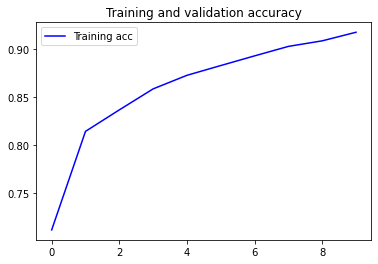

<Figure size 432x288 with 0 Axes>

In [623]:

acc = history.history['accuracy']
loss = history.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

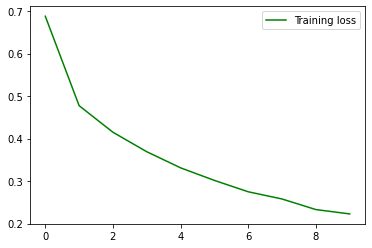

In [624]:
plt.plot(epochs, loss, 'g', label='Training loss')

plt.legend()
 
plt.show()

In [625]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = y_test[:-validation_size]
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 36)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

ValueError: ignored

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct, neutre_correct,neutre_cnt = 0, 0, 0, 0, 0,0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        elif np.argmax(Y_validate[x]) == 1:
            neutre_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    elif np.argmax(Y_validate[x]) == 1:
            neutre_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neutre_correct/neutre_cnt*100, "%")


In [ ]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)


In [ ]:
sentiment = model.predict(twt, batch_size=23, verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutre")
else:
    print("positive")

In [ ]:
twt2 = ['I am happy to see you']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt2)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt2 = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt2)

sentiment = model.predict(twt2, batch_size=32, verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutre")
else:
    print("positive")


In [ ]:
twt3 = ['nice to meet you']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt3 = tokenizer.texts_to_sequences(twt3)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt3 = pad_sequences(twt3, maxlen=28, dtype='int32', value=0)
print(twt3)

sentiment = model.predict(twt3, batch_size=32, verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutre")
else:
    print("positive")